In [15]:
%matplotlib inline
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from scipy.ndimage.filters import laplace, generic_filter
from scipy.ndimage import (gaussian_gradient_magnitude, sobel,
                           maximum_filter, gaussian_laplace)

from dataset_utils import load_img, img_to_dataset, grid_plot, get_training_windows

from tensorflow import keras as K
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## loading the data

In [3]:
data_source = '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked/'
glob.glob(data_source + '*')

['/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked/NUC',
 '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked/ACA',
 '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked/ZIA',
 '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked/HOM']

In [5]:
class_files = {}
for name in ['NUC', 'ACA', 'ZIA', 'HOM']:
    files = list(sorted(glob.glob(f'{data_source}/{name}/*')))
    class_files[name] = files
    
class_files

{'NUC': ['/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/000.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/001.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/002.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/003.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/004.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/005.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/006.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/007.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/008.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/009.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dataset/masked//NUC/010.png',
  '/net/people/plgmatisz/antibodies/data/antibodies/DL-dat

In [20]:
class_indices = {
    'NUC': 0,
    'ACA': 1,
    'ZIA': 2,
    'HOM': 3
}

masked_data = {}

for name, files in class_files.items():
    class_index = class_indices[name]
    imgs = [load_img(f, grayscale=True) for i, f in enumerate(files) if i % 2 == 1]
    masks = [load_img(f, grayscale=True) for i, f in enumerate(files) if i % 2 == 0]
    masked_data[name] = []
    
    for img, mask in zip(imgs, masks):
        masked_data[name].append((img, mask, class_index))

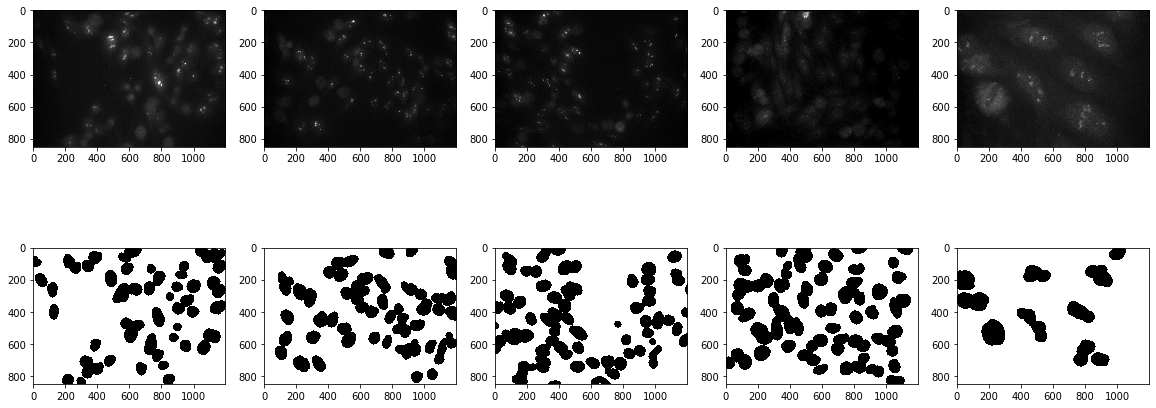

In [14]:
sample_imgs = [masked_data[i][0] for i in range(5)]
sample_masks = [masked_data[i][1] for i in range(5)]

plt.figure(figsize=(20, 8))
grid_plot(sample_imgs + sample_masks, cmap='gray', rows=2, cols=5)

## defining datasets

In [46]:
def extract_meaningful_crops(img, mask, crop_size, crop_stride, mask_fill_threshold):
    
    bin_mask = mask < 100
    _, pos = get_training_windows(img, bin_mask, 
                                  pos_threshold=mask_fill_threshold, neg_threshold=1,
                                  window_size=crop_size, stride=crop_stride)
    
    return pos

def get_dataset_from_records(masked_records, crop_size, crop_stride, mask_fill_threshold):
    
    X = []
    y = []
    
    for record in masked_records:
        img, mask, class_index = record
        crops = extract_meaningful_crops(img, mask, crop_size, crop_stride, mask_fill_threshold)
        
        X.append(crops)
        y.append(np.full(crops.shape[0], fill_value=class_index))
        
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    return X, y

def get_dataset(masked_data, train_samples, test_samples, crop_size, crop_stride, mask_fill_threshold):
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for name, data in masked_data.items():
        
        train_count = 0
        test_count = 0
        
        tmp_X_train = []
        tmp_y_train = []
        tmp_X_test = []
        tmp_y_test = []
        
        for record in data:
            X, y = get_dataset_from_records([record], crop_size, crop_stride, mask_fill_threshold)
            
            if train_count < train_samples:
                train_count += X.shape[0]
                tmp_X_train.append(X)
                tmp_y_train.append(y)
                
            elif test_count < test_samples:
                test_count += X.shape[0]
                tmp_X_test.append(X),
                tmp_y_test.append(y)
                
        tmp_X_train = np.concatenate(tmp_X_train)
        tmp_y_train = np.concatenate(tmp_y_train)
        tmp_X_test = np.concatenate(tmp_X_test)
        tmp_y_test = np.concatenate(tmp_y_test)
                
        X_train.append(tmp_X_train[:train_samples])
        y_train.append(tmp_y_train[:train_samples])
        X_test.append(tmp_X_test[:test_samples])
        y_test.append(tmp_y_test[:test_samples])
        print(f'finished {name}, train samples: {train_count}, test_samples: {test_count}')
                
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
                
    return X_train, y_train, X_test, y_test

In [47]:
%%time
dataset = get_dataset(masked_data, train_samples=2000, test_samples=500,
                      crop_size=128, crop_stride=16, mask_fill_threshold=0.6)

finished NUC, train samples: 2239, test_samples: 840
finished ACA, train samples: 2135, test_samples: 739
finished ZIA, train samples: 2498, test_samples: 548
finished HOM, train samples: 2193, test_samples: 689
CPU times: user 14.7 s, sys: 26.8 s, total: 41.5 s
Wall time: 41.5 s


In [49]:
X_train, y_train, X_test, y_test = dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 128, 128) (8000,) (2000, 128, 128) (2000,)


## network training

In [50]:
from tensorflow.keras.applications import resnet_v2, inception_v3

In [52]:
input_tensor = K.layers.Input(shape=(128, 128, 3))
base_model = inception_v3.InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [53]:
model_top = K.layers.Flatten()(base_model.output)
model_top = K.layers.Dense(4, activation='softmax')(model_top)

In [54]:
full_model = K.Model(base_model.input, model_top, name='cells-transfer')
full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
full_model.summary()

Model: "cells-transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [55]:
%%time

X_train_prep = X_train.copy()
X_train_prep = np.repeat(X_train_prep[..., np.newaxis], 3, -1)
np.apply_along_axis(resnet_v2.preprocess_input, arr=X_train_prep, axis=0)

X_test_prep = X_test.copy()
X_test_prep = np.repeat(X_test_prep[..., np.newaxis], 3, -1)
np.apply_along_axis(resnet_v2.preprocess_input, arr=X_test_prep, axis=0)

CPU times: user 29.1 s, sys: 2.18 s, total: 31.3 s
Wall time: 31.3 s


array([[[[-0.97647059, -0.97647059, -0.97647059],
         [-0.99215686, -0.99215686, -0.99215686],
         [-0.99215686, -0.99215686, -0.99215686],
         ...,
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-0.97647059, -0.97647059, -0.97647059]],

        [[-0.99215686, -0.99215686, -0.99215686],
         [-0.98431373, -0.98431373, -0.98431373],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.99215686, -0.99215686, -0.99215686],
         [-1.        , -1.        , -1.        ],
         [-0.99215686, -0.99215686, -0.99215686]],

        [[-0.97647059, -0.97647059, -0.97647059],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.99215686, -0.99215686, -0.99215686],
         [-0.99215686, -0.99215686, -0.99215686],
         [-0.98431373, -0.98431373, -0.98431373]],

        ...,

        [[-0.97647059, -0.97647059, -0

In [56]:
X_train_prep.shape

(8000, 128, 128, 3)

In [59]:
# run after pretraining

base_model.trainable = True
full_model.compile(optimizer=K.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy', metrics=['accuracy'])

full_model.summary()

Model: "cells-transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [60]:
history = full_model.fit(
    X_train_prep, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_test_prep, y_test)
)

Epoch 1/10
32/32 [==============================] - 32s 1s/step - loss: 0.2004 - accuracy: 0.9323 - val_loss: 7.6012 - val_accuracy: 0.6575
Epoch 2/10
32/32 [==============================] - 29s 922ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 4.6790 - val_accuracy: 0.7190
Epoch 3/10
32/32 [==============================] - 30s 922ms/step - loss: 8.2451e-04 - accuracy: 0.9998 - val_loss: 3.1606 - val_accuracy: 0.7675
Epoch 4/10
32/32 [==============================] - 29s 920ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 1.5604 - val_accuracy: 0.7795
Epoch 5/10
32/32 [==============================] - 30s 923ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.7129 - val_accuracy: 0.9025
Epoch 6/10
32/32 [==============================] - 30s 924ms/step - loss: 6.4366e-05 - accuracy: 1.0000 - val_loss: 0.4726 - val_accuracy: 0.9180
Epoch 7/10
32/32 [==============================] - 29s 922ms/step - loss: 3.4045e-05 - accuracy: 1.0000 - val_loss: 0.2950 - val_accurac

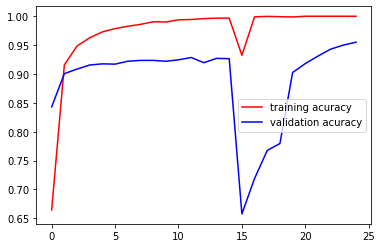

In [61]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

acc = np.concatenate([acc, history.history['accuracy']])
val_acc = np.concatenate([val_acc, history.history['val_accuracy']])

plt.plot(acc, c='red', label='training accuracy')
plt.plot(val_acc, c='blue', label='validation accuracy')
plt.legend()

In [62]:
pred_test = full_model.predict(X_test_prep).reshape(-1)